# Return of the Lander: Upgrading CMA-ME to CMA-MAE

In the [previous tutorial](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html), we showed how to implement the CMA-ME algorithm in pyribs to tackle the lunar lander problem. CMA-ME enabled us to search for a diverse collection of high-performing lunar lander agents, including agents which landed like a space shuttle as shown below.

In [ ]:
from IPython.display import display, HTML
display(HTML("""<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-left.mp4" type="video/mp4" /></video>"""))

Recent work introduced [Covariance Matrix Adaptation MAP-Annealing (CMA-MAE)](https://arxiv.org/abs/2205.10752), an algorithm which builds on and improves CMA-ME. CMA-MAE not only has strong theoretical guarantees; it also empirically outperforms CMA-ME in a variety of domains. The below heatmaps compare CMA-MAE and CMA-ME on the 100-dimensional sphere linear projection benchmark described in [Fontaine 2020](https://arxiv.org/abs/1912.02400), and as we can see, CMA-MAE does a much better job of populating the archive with high-performing solutions than CMA-ME.

In [2]:
display(HTML("""<video width="720" height="auto" autoplay muted playsinline loop><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/cma-mae-vs-cma-me-imp.mp4" type="video/mp4" /></video>"""))

In this tutorial, we'll show you how to implement CMA-MAE in pyribs. To understand how CMA-MAE operates, we'll start with the sphere benchmark function mentioned above. Then, we'll apply CMA-MAE to the same lunar lander problem as in the previous tutorial and see how it performs.

## Setup

First, let's install pyribs and import utilities like in the previous tutorial.

In [ ]:
%pip install ribs[visualize] gymnasium[box2d]==0.27.0 "moviepy>=1.0.0"

# An uninstalled version of decorator is occasionally loaded. This loads the
# newly installed version of decorator so that moviepy works properly -- see
# https://github.com/Zulko/moviepy/issues/1625
import importlib
import decorator
importlib.reload(decorator)

import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt

## The Sphere Linear Projection Benchmark

Next, let's define the sphere function which we'll be using as we introduce CMA-MAE. This benchmark, introduced in [Fontaine 2020](https://arxiv.org/abs/1912.02400), challenges a QD algorithm's ability to handle distortions in the measure space. The objective function is fairly simple: it is the negative [sphere function](https://en.wikipedia.org/wiki/Test_functions_for_optimization) $f(\mathbb{\theta}) = -\sum_{i=1}^n \theta_i^2$, albeit the center is shifted to $[0.4 * 5.12, 0.4 * 5.12, ...]$ so that the optimal solution is not the zero vector. Furthermore, the outputs of the function are normalized to the range $[0, 100]$ as the default objectives are negative.

Meanwhile, the measure function is a linear projection, i.e., a weighted sum of the components of the input vector. Given a clip function defined as follows:

$$clip(\theta_i) = \begin{cases} \theta_i & \text{if} -5.12 \le \theta_i \le 5.12 \\ 5.12/\theta_i & \text{otherwise} \end{cases}$$

Then the measure function outputs a 2D vector:

$$m(\mathbb{\theta}) = \left( \sum_{i=1}^{\lfloor\frac{n}{2}\rfloor}clip(\theta_i), \sum_{i=\lfloor\frac{n}{2}\rfloor+1}^n clip(\theta_i) \right)$$

This measure function creates distortion in the measure space which prevents a QD algorithm from easily reaching the bounds of the archive. We recommend referring to Appendix B of [Fontaine 2022](https://arxiv.org/abs/2205.10752) to better understand this benchmark and its properties. 

In [20]:
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
      solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
      objective_batch (np.ndarray): (batch_size,) batch of objectives.
      measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Compute gradient of the objective
    objective_grad_batch = -2 * (solution_batch - sphere_shift)

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_indices = np.where(np.logical_or(clipped > 5.12, clipped < -5.12))
    clipped[clip_indices] = 5.12 / clipped[clip_indices]
    measures_batch = np.concatenate(
      (
          np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
          np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
      ),
      axis=1,
    )

    # Compute gradient of the measures
    derivatives = np.ones(solution_batch.shape)
    derivatives[clip_indices] = -5.12 / np.square(solution_batch[clip_indices])

    mask_0 = np.concatenate((np.ones(dim // 2), np.zeros(dim - dim // 2)))
    mask_1 = np.concatenate((np.zeros(dim // 2), np.ones(dim - dim // 2)))

    d_measure0 = derivatives * mask_0
    d_measure1 = derivatives * mask_1

    measures_grad_batch = np.stack((d_measure0, d_measure1), axis=1)

    return (
      objective_batch,
      objective_grad_batch,
      measures_batch,
      measures_grad_batch,
    )

## Introducing CMA-MAE



After CMA-ME finds a high-objective solution, all subsequent solutions found in the same region will be neglected since they have much lower objective value. Consequently, CMA-ME will rapidly move away from a high-performing solution after discovering it.

The intuition of CMA-MAE is that there could be value in discovering more solutions in a high-objective region. For instance, there could be even better solutions in the same region, but CMA-ME will move away from the region regardless if it does not discover a better solution in the next few iterations.

CMA-MAE overcomes this problem by using a threshold value (not the objective value) to determine whether a new solution is accepted by the archive. Formally, a new solution $\theta'$ in cell $e$ is accepted to the archive if and only if $f(\theta') > t_e$, where $t_e$ is the threshold of cell $e$, and $f(\theta')$ computes the objective value of $\theta'$. The improvement value of a solution is calculated as $$\Delta = f(\theta') - t_e$$

Furthermore, after $\theta'$ is accepted into cell $e$, $t_e$ is updated according to the following equation $$t_e \gets (1 - \alpha) t_e + \alpha f(\theta')$$ where the constant $\alpha$ denotes the _archive learning rate_ and controls how quickly the threshold is adapted.

When $\alpha = 1$, **CMA-MAE behaves like CMA-ME**, with the improvement values $\Delta$ quickly dropping to zero (an observation that [Fontaine 2022](https://arxiv.org/abs/2205.10752) discusses more formally).

When a cell does not yet have a solution, its threshold is initialized to a predefined minimum threshold $min_f$.

Using an example from the paper:
> Consider discovering solutions in the same cell with objective value 100 in 5 consecutive iterations. The improvement values computed by CMA-ME would be 100, 0, 0, 0, 0, thus CMA-ME would move rapidly away from this cell. The improvement values computed by CMA-MAE with α = 0.5 would diminish smoothly as follows: 100, 50, 25, 12.5, 6.25, enabling further exploitation of the high-performing region.

## CMA-MAE with pyribs

We will create a `GridArchive` with the following parameters from Fontaine 2022. In particular, we use a learning rate $\alpha = 0.01$ and minimum threshold $min_f = 0$.

**Note: If your solutions $\theta'$ consistently have objective values $f(\theta') = min_f$, you may need to set $min_f$ to be slightly smaller so that these solutions are accepted into the archive. This is because solutions are accepted if and only if $f(\theta') > t_e$. Thus, if $f(\theta') = t_e$, then $\theta'$ will not be accepted.**

In [21]:
from ribs.archives import GridArchive

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

Since solutions are added to the archive based on the cell's **threshold** rather than the cell's **objective**, it is possible for CMA-MAE to make backwards progress. Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current occupant, which results in overwriting the **better** solution.

For this reason, CMA-MAE requires a separate **result archive** that keeps track of the best solutions encountered in each cell. Fortunately, this is exactly the default behavior of `GridArchive`, with `learning_rate = 0` and `threashold_min=-inf`.

In [22]:
result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

CMA-MAE is based on CMA-ME. The original conception of CMA-MAE uses 15 instances of `EvolutionStrategyEmitter` as defined in the following cell.

> We encourage you to play around with the parameters of this emitter (i.e. `x0`, `sigma0`, `ranker`, `selection_rule`, `restart_rule`, and `batch_size`), or experiment with different combination of emitters (such as mixing different emitters together). The setup that we are using might not be optimal!

In [23]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

Finally, we can create a `Scheduler` with an additional parameter `result_archive`. The `Scheduler` class will be responsible for interacting with the `result_archive` so that it keeps track of the best solutions.

In [24]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Aside: Setting learning_rate and threshold_min

The pyribs archives (except for `SlidingBoundariesArchive`) feature a `learning_rate` and `threshold_min` parameter which lead to different behaviors. In particular, the original CMA-ME computed improvement with two stages: (1) the solution's status (i.e., whether it was new, improved an existing cell in the archive, or was not inserted at all), and (2) a value which depended on the status.

In contrast, CMA-MAE computes a single improvement value $\Delta$ which is computed in the same manner regardless of the solution's status. However, this may lead to slightly different behavior than CMA-ME in some cases, and CMA-MAE also requires $min_f$ to always be passed in, while CMA-ME does not.

Thus, we have made it possible to activate the original CMA-ME behavior by passing in $\alpha=1$ and $min_f=-\infty$. The table below shows all the possible values of `learning_rate` and `threshold_min` for the archives.

| `learning_rate` ($\alpha$) | `threshold_min` ($min_f$) | Improvement values          |
| -------------------------- | ------------------------- | --------------------------- |
| $1$                        | $-\infty$                 | Two-stage (CMA-ME)          |
| $0\le\alpha\le1$           | (any value)               | $f(\theta) - t_e$ (CMA-MAE) |

Supporting this behavior introduces several additional considerations:
* When performing batch addition via the `add()` method on an archive with the CMA-ME settings, we update the threshold by taking the maximum objective value, as opposed to applying the CMA-MAE batch addition rule in Appendix H of Fontaine 2022 (however, the batch addition rule is applied when using CMA-MAE settings).
* When using the CMA-ME settings, using any ranker which is not `TwoStage` is not advisable, as CMA-ME is only designed to work with two-stage ranking.

## Running CMA-MAE (5 minutes on Google Colab)

Now we run CMA-MAE for 10000 iterations in accordance with the experiments in [Fontaine 2022](https://arxiv.org/abs/2205.10752). Note that we report the **normalized QD score** here, which is the QD score divided by the number of cells in the archive.

In [25]:
total_itrs = 10_000

for itr in range(1, total_itrs + 1):
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output progress every 500 iteration or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        print(f"Iteration {itr} | Archive Coverage:"
              f"{result_archive.stats.coverage * 100:.3f}% "
              f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

Iteration 500 | Archive Coverage:55.590% Normalized QD Score: 45.338
Iteration 1000 | Archive Coverage:67.090% Normalized QD Score: 52.124
Iteration 1500 | Archive Coverage:71.610% Normalized QD Score: 55.109
Iteration 2000 | Archive Coverage:73.800% Normalized QD Score: 56.661
Iteration 2500 | Archive Coverage:76.170% Normalized QD Score: 58.163
Iteration 3000 | Archive Coverage:76.950% Normalized QD Score: 59.040
Iteration 3500 | Archive Coverage:78.500% Normalized QD Score: 60.079
Iteration 4000 | Archive Coverage:79.090% Normalized QD Score: 60.708
Iteration 4500 | Archive Coverage:79.130% Normalized QD Score: 61.067
Iteration 5000 | Archive Coverage:79.300% Normalized QD Score: 61.383
Iteration 5500 | Archive Coverage:79.540% Normalized QD Score: 61.772
Iteration 6000 | Archive Coverage:79.680% Normalized QD Score: 62.018
Iteration 6500 | Archive Coverage:79.870% Normalized QD Score: 62.268
Iteration 7000 | Archive Coverage:79.910% Normalized QD Score: 62.377
Iteration 7500 | Arch

## Visualization

Now we visualize the result archive with `grid_archive_heatmap` (as previously noted, the archive used in the main algorithm does not always hold the best solutions, while the result archive does).

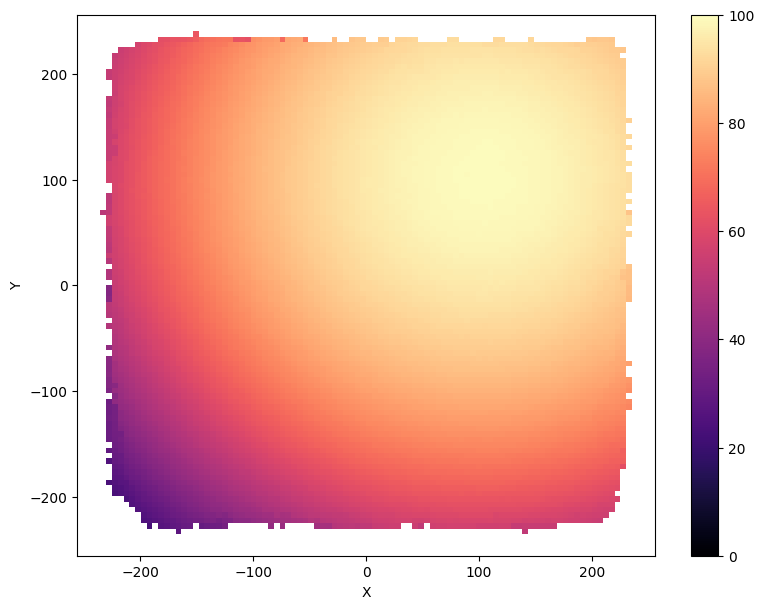

In [26]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.ylabel("Y")
plt.xlabel("X")

## Exploring the Effect of Learning Rate $\alpha$

In the previous section, we explored CMA-MAE using $\alpha = 0.01$, but what about other settings of $\alpha$? Here we explore how different learning rates affect CMA-MAE on the sphere function. We first define a method for creating a scheduler with a given `learning_rate`.

In [27]:
def create_scheduler(learning_rate):
    solution_dim = 100
    archive_dims = (100, 100)
    max_bound = solution_dim / 2 * 5.12
    bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]

    archive = GridArchive(solution_dim=solution_dim,
                          dims=archive_dims,
                          ranges=bounds,
                          learning_rate=learning_rate,
                          threshold_min=0)

    result_archive = GridArchive(solution_dim=solution_dim,
                                 dims=archive_dims,
                                 ranges=bounds)

    emitters = [
      EvolutionStrategyEmitter(
          archive,
          x0=np.zeros(solution_dim),
          sigma0=0.5,
          ranker="imp",
          selection_rule="mu",
          restart_rule="basic",
          batch_size=36,
      ) for _ in range(15)
    ]

    return Scheduler(archive, emitters, result_archive=result_archive)

Then, we run the experiments with various learning rates while keeping track of the performance (normalized QD score and archive coverage) for each learning rate. **This took 15 minutes on Google Colab.**

> Note that the iterations are adjusted from `10000` to `5000` to save time.

In [28]:
from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

# The learning rates that we run CMA-MAE with.
learning_rates = [0, 0.001, 0.01, 0.1, 1]

# Run for 5000 iterations.
total_itrs = 5000

# Tracks the metrics of all the experiments.
all_metrics = {}

for learning_rate in learning_rates:
    # Create scheduler
    scheduler = create_scheduler(learning_rate)
    result_archive = scheduler.result_archive

    metrics = {
    "Normalized QD Score": {
        "x": [0],
        "y": [0.0],
    },
    "Archive Coverage": {
        "x": [0],
        "y": [0.0],
    },
    }

    print(f"Running CMA-MAE with learning_rate = {learning_rate}")
    for itr in range(1, total_itrs + 1):
        solution_batch = scheduler.ask()
        objective_batch, _, measure_batch, _ = sphere(solution_batch)
        scheduler.tell(objective_batch, measure_batch)

        # Output and record metrics every 250 iteration or on the final iteration.
        if itr % 250 == 0 or itr == total_itrs:
            print(f"Iteration {itr} | Archive Coverage:"
                  f"{result_archive.stats.coverage * 100:.3f}% "
                  f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

            metrics["Normalized QD Score"]["x"].append(itr)
            metrics["Normalized QD Score"]["y"].append(result_archive.stats.norm_qd_score)
            metrics["Archive Coverage"]["x"].append(itr)
            metrics["Archive Coverage"]["y"].append(result_archive.stats.coverage * 100)

        all_metrics[learning_rate] = metrics


Running CMA-MAE with learning_rate = 0
Iteration 250 | Archive Coverage:3.060% Normalized QD Score: 2.958
Iteration 500 | Archive Coverage:3.060% Normalized QD Score: 2.958
Iteration 750 | Archive Coverage:3.440% Normalized QD Score: 3.328
Iteration 1000 | Archive Coverage:3.440% Normalized QD Score: 3.328
Iteration 1250 | Archive Coverage:3.590% Normalized QD Score: 3.472
Iteration 1500 | Archive Coverage:3.670% Normalized QD Score: 3.548
Iteration 1750 | Archive Coverage:3.670% Normalized QD Score: 3.548
Iteration 2000 | Archive Coverage:3.760% Normalized QD Score: 3.637
Iteration 2250 | Archive Coverage:3.760% Normalized QD Score: 3.637
Iteration 2500 | Archive Coverage:3.890% Normalized QD Score: 3.763
Iteration 2750 | Archive Coverage:3.890% Normalized QD Score: 3.764
Iteration 3000 | Archive Coverage:3.930% Normalized QD Score: 3.803
Iteration 3250 | Archive Coverage:4.000% Normalized QD Score: 3.870
Iteration 3500 | Archive Coverage:4.030% Normalized QD Score: 3.899
Iteration 37

Now, we can plot the metrics for each learning rate.

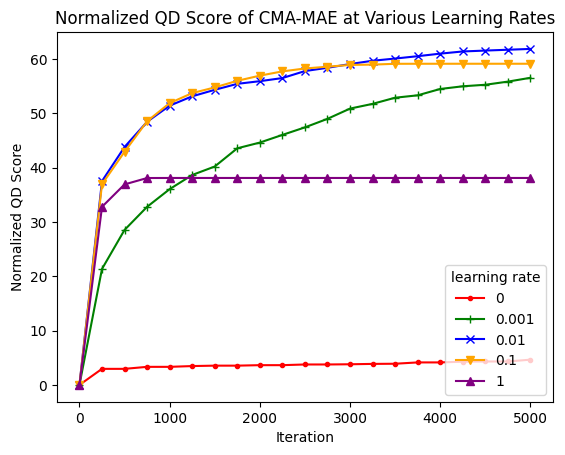

In [29]:
# Add markers for accessiblity.
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'purple'],
                         marker=['.', '+', 'x', 'v', '^'])

for learning_rate in learning_rates:
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Normalized QD Score"]["x"], metrics["Normalized QD Score"]["y"])
    plt.title("Normalized QD Score of CMA-MAE at Various Learning Rates")
    plt.xlabel("Iteration")
    plt.ylabel("Normalized QD Score")
plt.legend(learning_rates, title="learning rate")
plt.show()

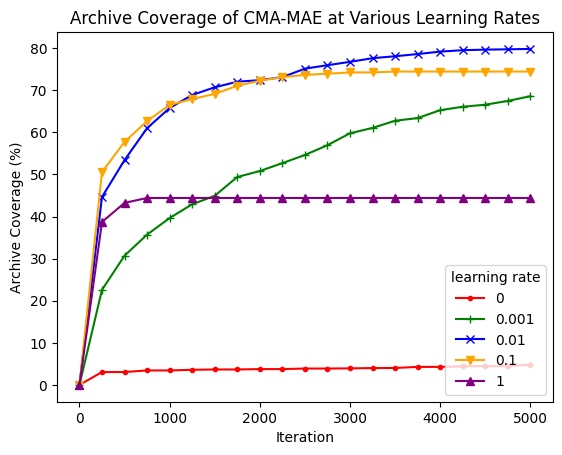

In [30]:
# Add markers for accessiblity.
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'purple'],
                         marker=['.', '+', 'x', 'v', '^'])

for learning_rate in learning_rates:
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Archive Coverage"]["x"], metrics["Archive Coverage"]["y"])
    plt.title("Archive Coverage of CMA-MAE at Various Learning Rates")
    plt.xlabel("Iteration")
    plt.ylabel("Archive Coverage (%)")
plt.legend(learning_rates, title="learning rate")
plt.show()

From the plots, we observe the following:

- With learning rate 0, the algorithm makes no progress in exploring the archive, resulting in the lowest QD score.
- With learning rate 1, the algorithm stops making progress after around 500 iterations (recall that this is the behavior of CMA-ME).
- With learning rate 0.001, the algorithm falls behind CMA-ME but consistently makes progress in exploring the archive, eventually surpassing CMA-ME at around 1500 iterations.
- With learning rate 0.01 and 0.1, the algorithm makes quick progress, surpassing the performance of all other learning rate settings.

Finally, from this experiment we observe that learning rate 0.01 is more optimal for the sphere function as the number of iteration increases.

## Extension: CMA-MAEGA with pyribs

CMA-MAEGA, proposed in the same paper as CMA-MAE, is a variant of CMA-MAE that combines archive thresholds with Covariance Matrix Adaptation MAP-Elites via a Gradient Arborescence (CMA-MEGA).

> For more details on CMA-MEGA, refer to [Fontaine 2021](https://arxiv.org/abs/2106.03894).

We can easily implement this algorithm by replacing `EvolutionStrategyEmitter` with `GradientArborescenceEmitter` in CMA-MAE.

In [31]:
from ribs.archives import GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler

solution_dim = 100
archive_dims = (100, 100)
max_bound = solution_dim / 2 * 5.12
bounds = [(-max_bound, max_bound), (-max_bound, max_bound)]
learning_rate = 0.01

archive = GridArchive(solution_dim=solution_dim,
                      dims=archive_dims,
                      ranges=bounds,
                      learning_rate=learning_rate,
                      threshold_min=0)

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=archive_dims,
                             ranges=bounds)

# Use GradientArborescenceEmitter instead of EvolutionStrategyEmitter.
emitters = [
    GradientArborescenceEmitter(
        archive,
        x0=np.zeros(solution_dim),
        sigma0=10.0,
        lr=1.0,
        ranker="imp",
        grad_opt="gradient_ascent",
        restart_rule="basic",
        bounds=None,
        batch_size=36,
    ) for _ in range(15)
]

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

We can run the algorithm in a similar fashion as CMA-MAE. Note that since `GradientArborescenceEmitter` uses gradient information of the objective function, we need to evaluate the gradient of the solutions returned by `ask_dqd` and pass the results to `tell_dqd`.

TODO: Link to the DQD tutorial here.

In [32]:
total_itrs = 4500

for itr in range(1, total_itrs + 1):
    # DQD ask-tell.
    solution_batch = scheduler.ask_dqd()

    (objective_batch, objective_grad_batch, measures_batch, measures_grad_batch) = sphere(solution_batch)

    objective_grad_batch = np.expand_dims(objective_grad_batch, axis=1)
    jacobian_batch = np.concatenate((objective_grad_batch, measures_grad_batch), axis=1)
    scheduler.tell_dqd(objective_batch, measures_batch, jacobian_batch)

    # ask-tell.
    solution_batch = scheduler.ask()
    objective_batch, _, measure_batch, _ = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Logging and output every 500 iteration or on final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        print(f"Iteration {itr} | Archive Coverage:"
              f"{result_archive.stats.coverage * 100:.3f}% "
              f"Normalized QD Score: {result_archive.stats.norm_qd_score:.3f}")

Iteration 500 | Archive Coverage:95.240% Normalized QD Score: 66.118
Iteration 1000 | Archive Coverage:98.940% Normalized QD Score: 74.638
Iteration 1500 | Archive Coverage:99.710% Normalized QD Score: 75.233
Iteration 2000 | Archive Coverage:99.950% Normalized QD Score: 75.305
Iteration 2500 | Archive Coverage:100.000% Normalized QD Score: 75.330
Iteration 3000 | Archive Coverage:100.000% Normalized QD Score: 75.343
Iteration 3500 | Archive Coverage:100.000% Normalized QD Score: 75.353
Iteration 4000 | Archive Coverage:100.000% Normalized QD Score: 75.359
Iteration 4500 | Archive Coverage:100.000% Normalized QD Score: 75.364


Notice that the CMA-MEGA fully explores the archive around 2000 iterations, much better than CMA-MAE. It also outperforms CMA-MAE. Now, let's visualize the result archive.

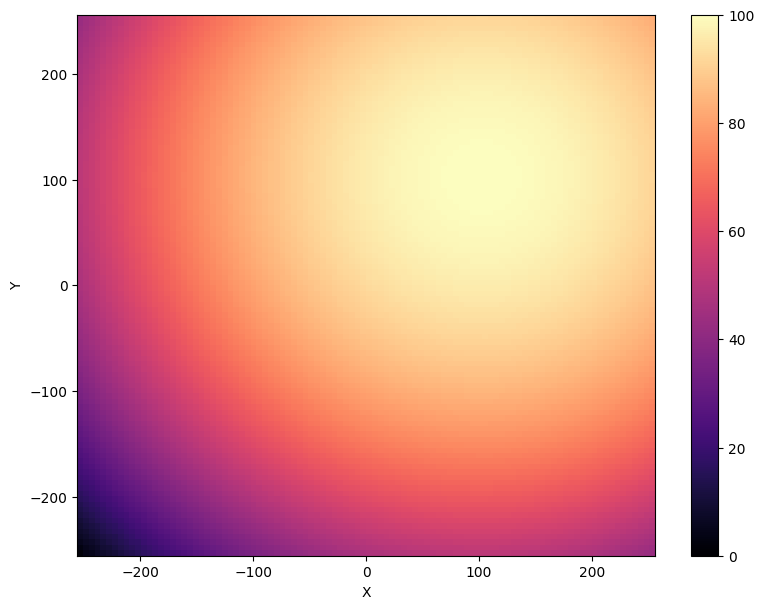

In [33]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)
plt.tight_layout()
plt.ylabel("Y")
plt.xlabel("X")
plt.show()

## Conclusion

In this tutorial, we introduced CMA-MAE and showed how it is implemented in pyribs. We also demonstrated CMA-MAE on the sphere function with several different settings of its learning rate parameter $\alpha$. Finally, we showed how these ideas extend to differentiable quality diversity with the CMA-MAEGA algorithm.

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_cma_mae,
  title   = {CMA-MAE and Archive Thresholds},
  author  = {David H. Lee and Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2022},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```